Loading f1_final_dataset.csv...
Encoding Track Specifics...

--- Applying Downsampling ---
Original Counts -> Successful: 109, Failed: 1639
Balanced Counts -> Successful: 109, Failed: 109

--- Training Gradient Boosting Model (Balanced) ---

--- Evaluating with Strategy Logic ---

Final Results (Balanced & Constrained):
F1 Score: 0.6667
Recall:   59.09%
Accuracy: 70.45%

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.73        22
           1       0.76      0.59      0.67        22

    accuracy                           0.70        44
   macro avg       0.72      0.70      0.70        44
weighted avg       0.72      0.70      0.70        44


Confusion Matrix:
[[18  4]
 [ 9 13]]


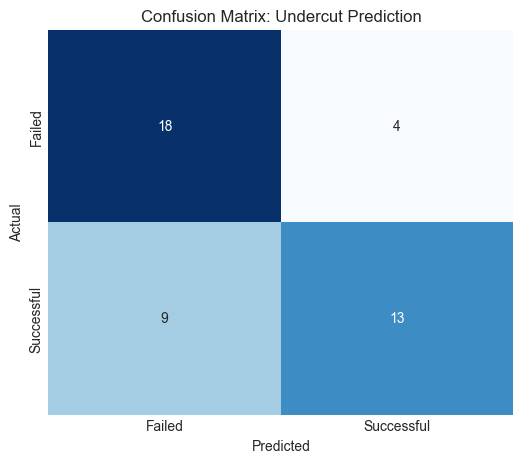


Model saved to f1_undercut_gb_balanced.pkl


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, classification_report
import joblib
import os

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
FILENAME = 'f1_final_dataset.csv'
MODEL_FILENAME = 'f1_undercut_gb_balanced.pkl'

# PHYSICS CONSTANTS FOR LOGIC CHECK
BASE_FRESH_TIRE_GAIN = 1.5 
TIRE_DEG_PER_LAP = 0.1      

# CONSTRAINT 2: STRATEGY (THE DIFFERENTIATOR)
NOT_UNDERCUT_THRESHOLD = 0.5

CORE_FEATURES = [
    'Gap_To_Ahead',       
    'Rival_Tyre_Age',     
    'Pace_Delta',         
    'Pit_Aggressiveness', 
    'StationaryDuration', 
    'InLap_Sec',          
    'OutLap_Sec'          
]

# ==========================================
# 2. DATA LOADING & PREPROCESSING
# ==========================================
print(f"Loading {FILENAME}...")
if not os.path.exists(FILENAME):
    print(f"Error: {FILENAME} not found.")
    exit()

df = pd.read_csv(FILENAME)

# 1. Clean Data
ml_data = df.dropna(subset=CORE_FEATURES + ['Undercut_Successful', 'GP_Name']).copy()

# 2. ONE-HOT ENCODING
print("Encoding Track Specifics...")
ml_data = pd.get_dummies(ml_data, columns=['GP_Name'], drop_first=False)

# ==========================================
# 3. DOWNSAMPLING (BALANCING THE DATASET)
# ==========================================
print("\n--- Applying Downsampling ---")

# Separate majority and minority classes
df_majority = ml_data[ml_data.Undercut_Successful == 0]
df_minority = ml_data[ml_data.Undercut_Successful == 1]

print(f"Original Counts -> Successful: {len(df_minority)}, Failed: {len(df_majority)}")

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority), # match minority n
                                   random_state=42) 

# Combine minority class with downsampled majority class
ml_data_balanced = pd.concat([df_majority_downsampled, df_minority])

print(f"Balanced Counts -> Successful: {len(ml_data_balanced[ml_data_balanced.Undercut_Successful==1])}, Failed: {len(ml_data_balanced[ml_data_balanced.Undercut_Successful==0])}")

# 3. Build Feature List
track_features = [col for col in ml_data_balanced.columns if col.startswith('GP_Name_')]
FULL_FEATURES = CORE_FEATURES + track_features

X = ml_data_balanced[FULL_FEATURES].values
y = ml_data_balanced['Undercut_Successful'].values

# Stratified Split (on the balanced data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preserve original X_test values for Physics Logic check later
# We need to map indices back to the DF
_, X_test_original_idx, _, _ = train_test_split(
    ml_data_balanced.index, y, test_size=0.2, random_state=42, stratify=y
)
X_test_original = ml_data_balanced.loc[X_test_original_idx]

# ==========================================
# 4. GRADIENT BOOSTING MODEL
# ==========================================
print("\n--- Training Gradient Boosting Model (Balanced) ---")

# Since data is perfectly balanced now, we don't strictly need class weights, 
# but sample weights can still help if specific examples are harder. 
# We'll train without weights first as the downsampling usually solves the bias.

model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)

# ==========================================
# 5. EVALUATION WITH PHYSICS CONSTRAINTS
# ==========================================
print("\n--- Evaluating with Strategy Logic ---")

probs = model.predict_proba(X_test)[:, 1]

# Constraint 1: Physics Rule (Dynamic Pace Gain Logic)
predicted_pace_gain = BASE_FRESH_TIRE_GAIN + (X_test_original['Rival_Tyre_Age'] * TIRE_DEG_PER_LAP)
mask_impossible = X_test_original['Gap_To_Ahead'] > predicted_pace_gain
probs[mask_impossible] = 0.0

# Constraint 2: Strategy Rule
mask_passive = X_test_original['Pit_Aggressiveness'] > NOT_UNDERCUT_THRESHOLD
probs[mask_passive] = 0.0

# Final Thresholding
CUSTOM_THRESHOLD = 0.5 # Can use 0.5 now since classes are balanced
y_pred_constrained = (probs > CUSTOM_THRESHOLD).astype(int)

# Metrics
f1 = f1_score(y_test, y_pred_constrained)
acc = accuracy_score(y_test, y_pred_constrained)
rec = recall_score(y_test, y_pred_constrained)

print(f"\nFinal Results (Balanced & Constrained):")
print(f"F1 Score: {f1:.4f}")
print(f"Recall:   {rec:.2%}")
print(f"Accuracy: {acc:.2%}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_constrained))

f1 = f1_score(y_test, probs)
acc = accuracy_score(y_test, probs)
rec = recall_score(y_test, probs)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_constrained)
print(cm)

# Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Failed', 'Successful'],
            yticklabels=['Failed', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Undercut Prediction')
plt.show()

joblib.dump(model, MODEL_FILENAME)
joblib.dump(FULL_FEATURES, 'gb_balanced_features.pkl')
print(f"\nModel saved to {MODEL_FILENAME}")